In [49]:
import numpy as np
from numpy import radians
from lib.cartpolesystem_new import CartPoleSystem, Cart, Pole, DCMotor
from lib.cartpoleenv_new import CartPoleEnv
from lib.direct_collocation_new import DirectCollocation
from lib.controllers_new import LQR
from time import perf_counter
from matplotlib import pyplot as plt
from lib.numerical import fe_step, rk4_step

In [50]:
dt = 0.01
g = 9.81

cart = Cart(0.5, 0.005, (-0.8, 0.8))
motor = DCMotor(0.02, 0.02, 0.2, 0.05, 8.7e-5, 8.7e-5, (-24, 24), (-1000, 1000))
poles = [Pole(1, 0.2, 0.1), Pole(0.5, 0.2, 0.1)]
n = len(poles)

system = CartPoleSystem(cart, motor, poles, g)

max_time = 10
N_env = int(max_time/dt)

env = CartPoleEnv(system, dt, N_env, rk4_step)
env.observation_space.shape

(6,)

{'variables': 128897, 'objective': 42898, 'eq_constraints': 42999, 'ineq_constraints': 42999, 'variables_mean': 1.565871303977159e-06, 'variables_total': 0.20183611346874386, 'objective_mean': 4.123989274467662e-06, 'objective_total': 0.17691089189611375, 'eq_constraints_mean': 0.0023225645966215218, 'eq_constraints_total': 99.86795509012882, 'ineq_constraints_mean': 0.0004941329614492637, 'ineq_constraints_total': 21.24722320935689}


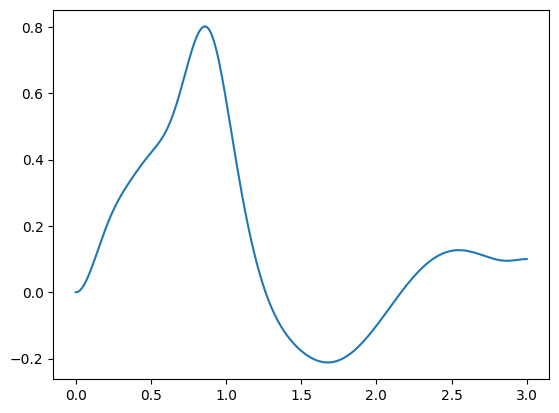

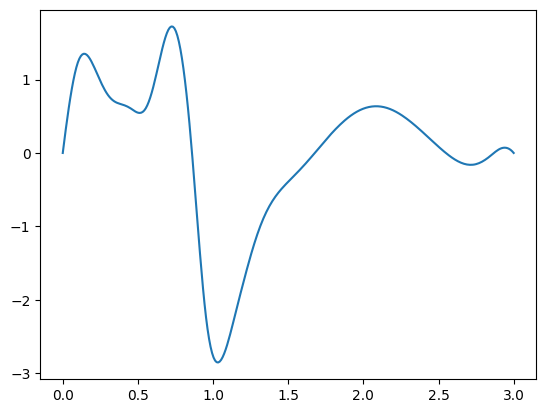

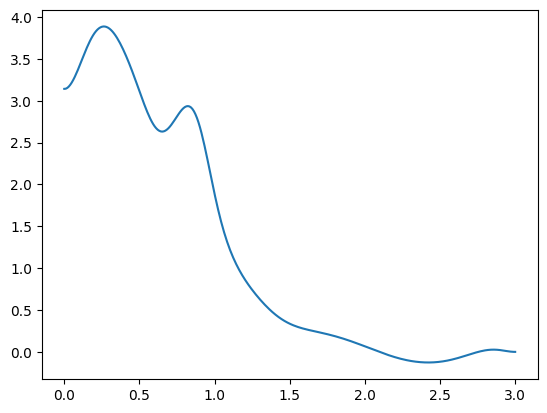

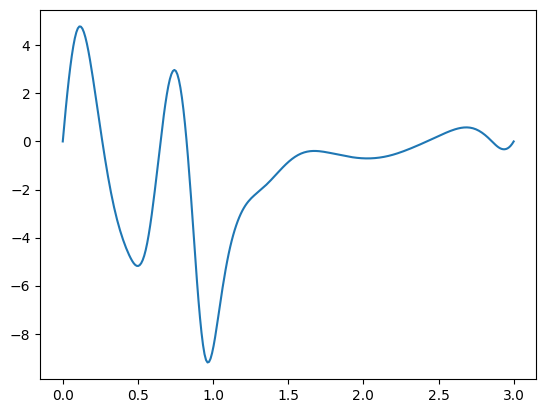

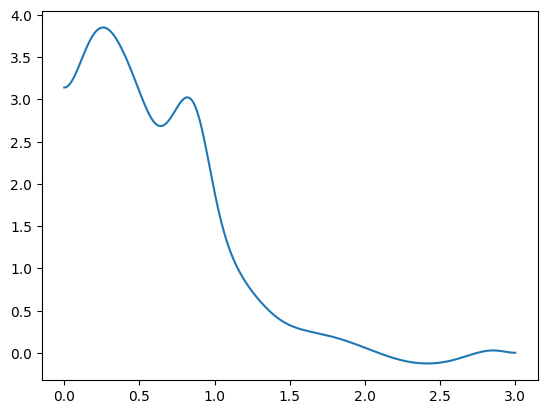

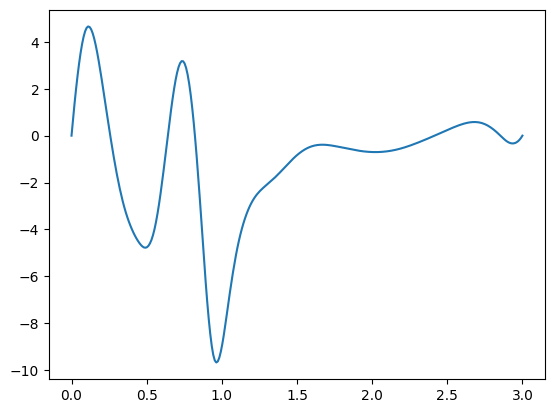

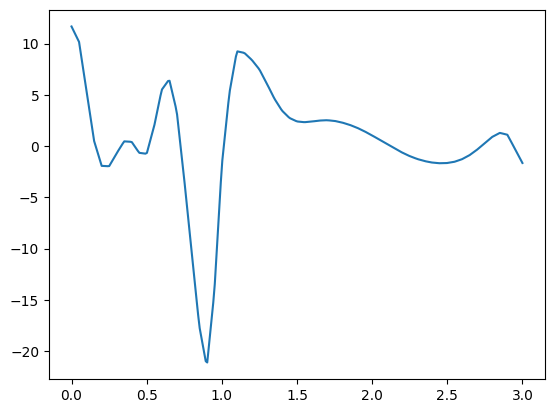

In [52]:
direct_collocation = DirectCollocation(
    61,
    system.differentiate, 
    system.state_lower_bound.shape[0],
    system.control_lower_bound.shape[0],
    system.constraints,
    0.01
)

x0 = np.array([0, 0, radians(180), 0, radians(180), 0])

r = np.array([0.1, 0, 0, 0, 0, 0])

end_time = 3
N = int(end_time/dt)

last_update = perf_counter()

states, controls = direct_collocation.make_controller(end_time, x0, r, N)

time = np.linspace(0, end_time, N)

for s in states.T:
    plt.plot(time, s)
    plt.show()
plt.plot(time, controls.T[0])
plt.show()


In [56]:
linearization_x0 = np.zeros(2+2*n)
linearization_u0 = np.array([0])

A0, B0 = system.linearize(linearization_x0, linearization_u0)

C = np.eye(2+2*n)
D = np.zeros((2+2*n, 1))

ct_dt = dt

lqr = LQR(ct_dt)

Q = np.eye(2+2*n)
R = np.diag([0.01])

A_d0, B_d0 = lqr.discretize(A0, B0, C, D)
K_d0 = lqr.calculate_K_lqr_d(A_d0, B_d0, Q, R)

In [57]:
As, Bs = np.vectorize(system.linearize, signature='(n),(m)->(n,n),(n,m)')(states, controls)
A_ds, B_ds = np.vectorize(lqr.discretize, signature='(n,n),(n,m),(n,n),(n,m)->(n,n),(n,m)')(As, Bs, C, D)
K_ds = np.vectorize(lqr.calculate_K_lqr_d, signature='(n,n),(n,m),(n,n),(m,m)->(m,n)')(A_ds, B_ds, Q, R)

In [58]:
last_update = perf_counter()
state, _ = env.reset(x0)

time_longer = 7
N_longer = int(time_longer/dt)

for i in range(N_longer):
    while perf_counter() < last_update + dt:
        pass
    last_update = perf_counter()

    if i < N*1:
        error = system.calculate_error(state, states[i])
        u_ff = controls[i]
        u_fb = lqr.feedback(K_ds[i], error)
        u = u_ff + u_fb
    else:
        error = system.calculate_error(state, states[-1])
        u = lqr.feedback(K_ds[-1], error)

    state, reward, done, msg, _ = env.step(u)
    env.render()

env.close()

AttributeError: 'NoneType' object has no attribute 'fill'